<a href="https://colab.research.google.com/github/pachterlab/COVID19-LA-County/blob/master/LA_County_Triggers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install packages
%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
import matplotlib.font_manager
import matplotlib as mpl
import pandas as pd
import io
import json
import datetime as dt

from IPython.display import HTML
=
# Only pandas >= v0.25.0 supports column names with spaces in querys
import requests
import warnings
import colorsys
warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's



fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

--2020-08-30 06:27:30--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19276189 (18M) [text/plain]
Saving to: ‘us-counties.csv’

us-counties.csv     100%[===================>]  18.38M  34.5MB/s    in 0.5s    

2020-08-30 06:27:31 (34.5 MB/s) - ‘us-counties.csv’ saved [19276189/19276189]



In [64]:
pop = 10_039_107
norm = 100_000
time_delta = 14 # days ie 2 weeks
lag = 2 # days
df = pd.read_csv("us-counties.csv").query("county=='Los Angeles'")
df = df.set_index(pd.to_datetime(df.date.values)).sort_index()

In [69]:
#data = (df["cases"].rolling(window="14d").sum()/pop*norm)[time_delta:]
data = np.array([df["cases"].values[i+14]-df["cases"].values[i] for i in range(0, df.shape[0]-14)])
dates = pd.to_datetime([df["date"].values[i+14] for i in range(0, df.shape[0]-14)])

per_diem = np.array([df["cases"].values[i+14]-df["cases"].values[i+13] for i in range(0, df.shape[0]-14)])

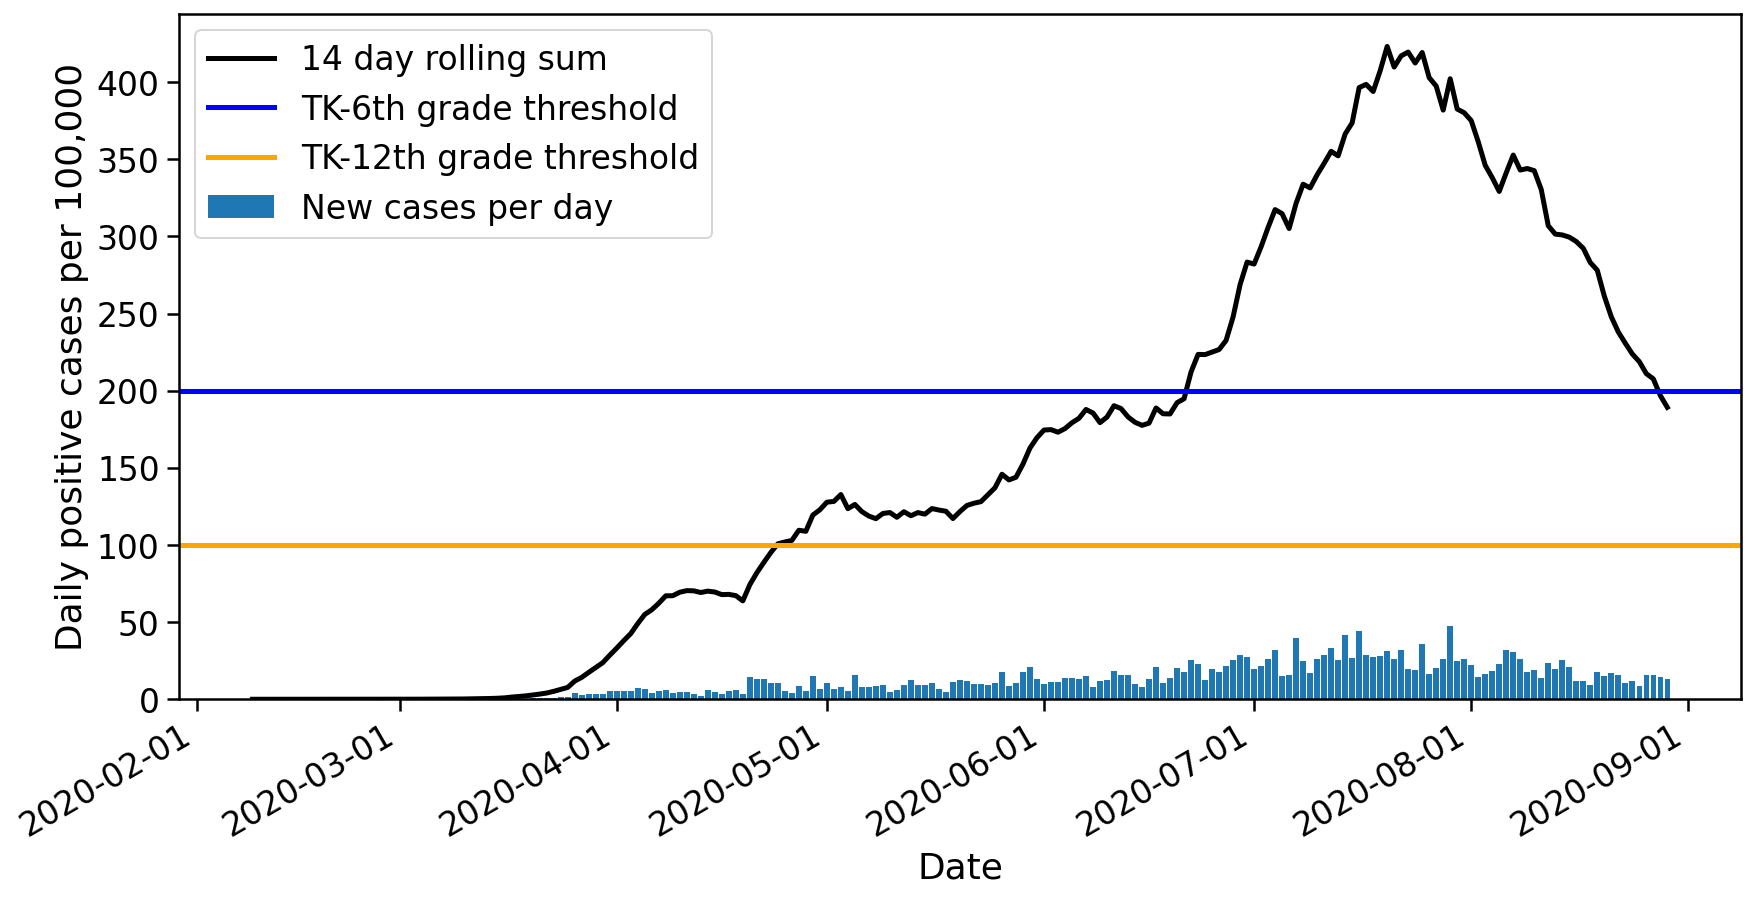

In [72]:
#@title LA County Threshold for Schools

fig, ax = plt.subplots(figsize=(14, 7))

x = dates.date
y = data*norm/pop

yy = per_diem*norm/pop
# xx = df.index.max() - dt.timedelta(days=lag)

ax.plot(x,  y, color="k", label="14 day rolling sum")
ax.bar(x, yy, label="New cases per day")
ax.axhline(y=200, color="blue", label="TK-6th grade threshold")
ax.axhline(y=100, color="orange", label="TK-12th grade threshold")
# ax.axvline(x=xx, label="Date after which data may be incomplete", color="grey", linestyle="--")

kwd = {
    "xlabel": "Date",
    "ylabel" : "Daily positive cases per 100,000"
}

myFmt = mpl.dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
# 
# ## Rotate date labels automatically
fig.autofmt_xdate()
# 
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**kwd)
ax.legend()

fig.show()